In [ ]:
import numpy as np
from scipy.stats import norm

## Exercise 1: Model Fitting

There is a file in this directory called "histogram_exercise.dat" which consists of of randomly generated samples from a Gaussian distribution with an unknown $\mu$ and $\sigma$. Using what you've learned about fitting data, load up this file using np.genfromtxt, fit a Gaussian curve to the data and plot both the curve and the histogram of the data. As always, label everything, play with the colors, and choose a judicious bin size.

Hint: if you attempt to call a function from a library or package that hasn't been imported, you will get an error.

In [ ]:
from scipy.stats import norm
test_hist = np.genfromtxt('histogram_exercise.dat')

mu, sigma = norm.fit(test_hist)
x = np.linspace(-1, 11, 1000)
pdf = norm.pdf(x, mu, sigma)

plt.plot(x, pdf, 'k-', linewidth=2)
plt.hist(test_hist, bins=25, color='dodgerblue', alpha=0.5, density=True, fill=True, histtype='step')
plt.title("Gaussian fit results: $\mu$ = %.2f, $\sigma$ = %.2f" % (mu, sigma)) 

plt.show()

## Exercise 2: Interpolation

Create a 1D interpolation along these arrays.

a. Plot both the data (as points) and the interpolation (as a dotted line).

b. Also plot the value of the interpolated function at x=325. What does the function look like to you?

In [4]:
x = np.array([0., 50., 100., 150., 200., 250., 300., 350., 400., 450., 500])
y = np.array([0., 7.071, 10., 12.247, 14.142, 15.811, 17.321, 18.708, 20., 21.213, 22.361])

#Solution Here
from scipy.interpolate import interp1d

interp = interp1d(x, y)
xnew = np.linspace(0, 500, 500)
ynew = interp(xnew)
y_325 = interp(325)
print(y_325)

plt.plot(xnew, ynew, ':', label='interpolation')
plt.plot(x, y, 'or', label='data')
plt.plot(325, y_325, color='black', markersize=12, marker="*", label="Value at 325")
plt.legend()
plt.show()

## Excercise 3: MCMC

A big part of astronomy is moving towards implementing Bayesian techniques. These techniques are useful as you can use prior information to inform new predictions, can assess the likelihod of the data you collected and provides a natural way to quantify the uncertainty on derived parameters. For this problem we will code up our very own MCMC algorithm using a technique called Metropolis Hastings algorithm.

We will walk throught he steps of how it works and you are tasked with translating it into code.

The Metropolis Hasting Sampling algorithm is an algorithm that takes your current start position and checks it against a trial value which we specify by inorporating a jump size to jump from our current value to another one. We then check to see if the new trial is more likely than the other one and if it is we keep the value but if it is not we reject the trial and stay at the current value and try again. We do this until we store our 10,000 values. 

For this problem we want to use MCMC to fit the Mass-Radius relation for M-dwarf Stars and see what values for the slope and y-intercept we get. The Mass-Radius relation is given by $R(M) = aM + b$ and our job is to find the best fit a and b values for the given data. In the directory is a file titled MCMC_Data.txt you will use this as this has the R, M and $\sigma_R$ values which you will need in the MCMC below. 


Steps: 

1. We need to decide how many values we want to ultimately aquire as part of the MCMC, it is good practice to start small so say L = 100 and then once the code works increase it to L = 100,000
2. We will need to jump from our current value to a test value so for this we need to specify a jump size which will be done by randomly generating a test value from a gaussian centered on your current value with a standard devation which we will provide use [$\sigma_a = 0.002, \sigma_b = 0.001$]
3. Come up with an initial guess for the parameters
4. Start a loop and specify it to stop after you have accepted the number L from Part 1. It should start off as a [1 X 2] matrix but you will eventually generate an [L X 2] Matrix.
5. Now we need to vary one parameter and check if we accept it or reject it. To this end generate a random number between 0-1 and round it. This will be the parameter to vary as a 0 means you will vary the first value and 1 means you will vary the second value
6. Now that we have which parameter we will vary we need to select another value for this we take the value and draw from a gaussian. So if the first value is the one that gets varied you have a current trial [$a_c, b_c$] and your trial test is [$a_t, b_c$] with $a_t$ being a random number drawn from a Gaussian $a_t = N(\mu = a_c, \sigma = \sigma_a)$, if second value is varied then you sample from a Gaussian $b_t = N(\mu = b_c, \sigma = \sigma_b)$
7. The goal is to compare which value has the highest likelihood between the current or trial values(ie: comparing [$a_c, b_c$] to [$a_t, b_c$] or [$a_c, b_c$] to [$a_c, b_t$]). At this step generate two sets of model predictions for the given $x_i$ ($m_{c, i} = a_c x_i + b_c$, $m_{t, i} = a_t x_i + b_c$ if first parameter is changing, $m_{t, i} = a_c x_i + b_t$ if second parameter is changing)
8. Compute the $\chi^2$ for the current and trial runs using $\chi_c^2 = \sum_i^N \frac{(R_i - m_{c, i})^2}{\sigma_{R, i}^2}$ and trial run being $\chi_t^2 = \sum_i^N \frac{(R_i - m_{t, i})^2}{\sigma_{R, i}^2}$
9. Compute the ratio r = $e^{-\chi_t^2/2}/e^{-\chi_c^2/2} = e^{-(\chi_t^2 - \chi_c^2)/2}$
10. Draw a random number P from a uniform distribution between 0 and 1, then compare if P < r (from part 9) and if it is accept the trial values and add them to your matrix, if P > r we reject the trial values and start from step 5 again
11. Repeat steps 5-10 until you reach the desired L from part 1

In [40]:
#reading in the Data
y, Mass, y_err = np.genfromtxt('MCMC_Data.txt', unpack = True, skip_header=1)

In [44]:
def Model(M, a, b):
    
    '''
    This will be the function that we will want to fit. In this particular example 
    we want to fit the Mass-Radius Relation R(M) = aM + b
    
    Inputs
    ----------------
    M: Mass of the star in solar masses
    a: Slope of the line
    b: y-intercept of the line
    
    
    Output(s)
    ----------------
    
    The Radius of the star for the given mass, slope and y-intercept
    
    '''
    
    
    return a * M + b


def Chi2(y, y_err, model):
    
    '''
    Function that will compute the chi2 for a given R, R_err, and model
    
    Inputs
    -----------
    R: The actual measured values of the radius
    R_err: the error in the measured values
    model: the model predictions
    
    Output(s)
    -----------
    chi2: The chi2 value of the model
    
    '''
    chi2 = np.sum((y - model)**2/y_err**2)
    
    return chi2

In [76]:
# define a dummy array that will store the values of the MCMC Chain
# This should be an L x 2 array/matrix
MCMC_chains = np.zeros((100000, 2))

# Sigma Declarations defined above
sigmas = [.002, .001]

##############
#Write the Metropolis-Hasting Sampling Algorithm here
##############

# Initial Starting Values
values = [1.04, 0.001]

counter = 0

#Decide which loop you want to use for this (ie: For-Loop/While-Loop)
while counter < 100000:
    
    # In the Loop
    # Generate a random number from 0-1 and round it, if 0 we will alter the a-parameter
    # if 1 we will alter the b-parameter
    
    tuning = round(np.random.uniform())
    
    #Now that you have which parameter we will vary
    #generate a new trial parameter by sampling from a gaussian 
    #centered on the current value with the appropriate sigma for the parameter

    if tuning == 0:
        
        new_val = np.random.normal(loc = values[tuning], scale = sigmas[tuning])
        trial_vals = np.array([new_val, values[-1]])
        #print(trial_vals)
        
    if tuning == 1:
        new_val = np.random.normal(loc = values[tuning], scale = sigmas[tuning])
        trial_vals = np.array([values[0], new_val])
        #print(trial_vals)
        
    
    #generate two model predictions
    #1. using the current parameter values
    #2. using the trial parameters
    
    current_param_model = Model(Mass, values[0], values[1])
    trial_param_model = Model(Mass, trial_vals[0], trial_vals[1])
    
    #Compute the chi2 between the two models
    current_model_chi2 = Chi2(y, y_err, current_param_model)
    
    trial_model_chi2 = Chi2(y, y_err, trial_param_model)

    #Compute the ratio r defined above
    r = np.exp(-(trial_model_chi2 - current_model_chi2)/2)

    
    # Randomly sample from a uniform distribution between 0-1 and compare 
    # the random sample to the ratio r
    # if the random number is less than r 
    # We accept the trial parameters
    # if the random number is larger than r we reject and keep the current parameters
    
    P = np.random.uniform()
    #print(P)
    
    if P < r:
        MCMC_chains[counter] = trial_vals
        counter += 1
        values = trial_vals
    
    #repeat these steps in the loop until your MCMC chain has the desired L entries
    
    

In [79]:
#During the MCMC fitting we need to get rid of the first few 1000 entries
#the reason for this is that the chain had not yet converged so we remove these
#with an L of 100000 remove the first 10000 values

param1_burnin = MCMC_chains[10000:, 0]#this would be column 1 in MCMC_chain
param2_burnin = MCMC_chains[10000:, 1]#this would be column 2 in MCMC_chain

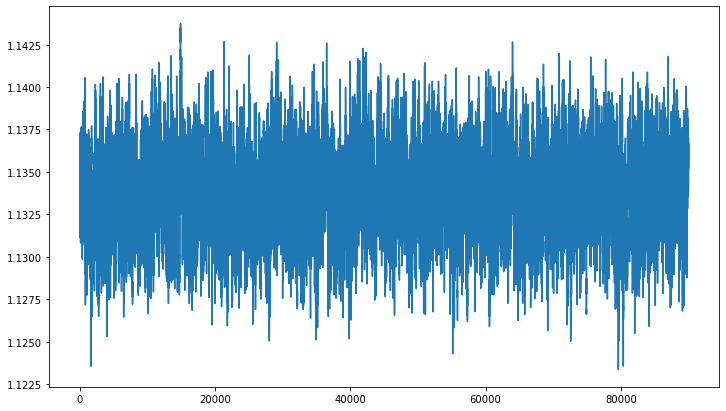

In [80]:
plt.figure(figsize = (12, 7))
plt.plot(param1_burnin)
plt.show()

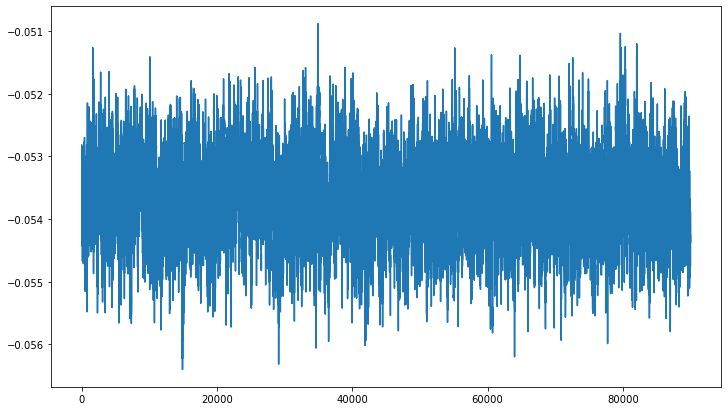

In [81]:
plt.figure(figsize = (12, 7))
plt.plot(param2_burnin)
plt.show()

In [ ]:
#If everything ran correctly these should look like shot noise 
#we can then make these into distributions and quantify the median as our value 
#and the error as the 16th and 84th percentile interval

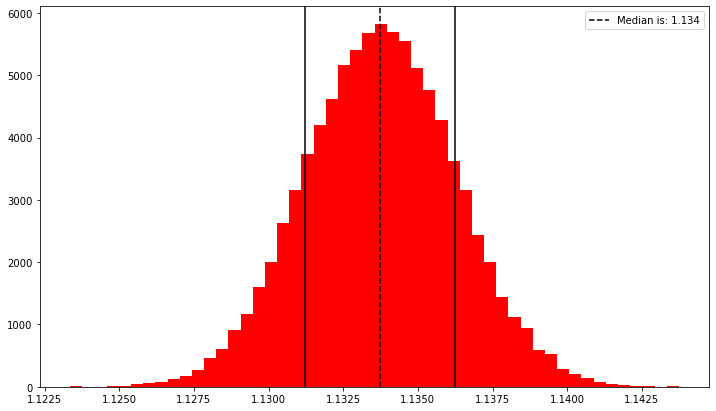

In [94]:
#Make a histogram of each quantity and make sure to make the plot as informative as possible
#ie: include title, x and y labels and any legends if necessary

plt.figure(figsize = (12, 7))
plt.hist(param1_burnin, bins = 50, color = 'red')
plt.ylabel('Counts')
plt.xlabel('Parameter 1 Values Explored')
plt.axvline(np.percentile(param1_burnin, q = 16), color = 'black')
plt.axvline(np.median(param1_burnin), 
            color = 'black', linestyle = '--', 
            label = f'Median is: {np.median(param1_burnin):.3f}')
plt.axvline(np.percentile(param1_burnin, q = 84), color = 'black')
plt.legend()
plt.show()

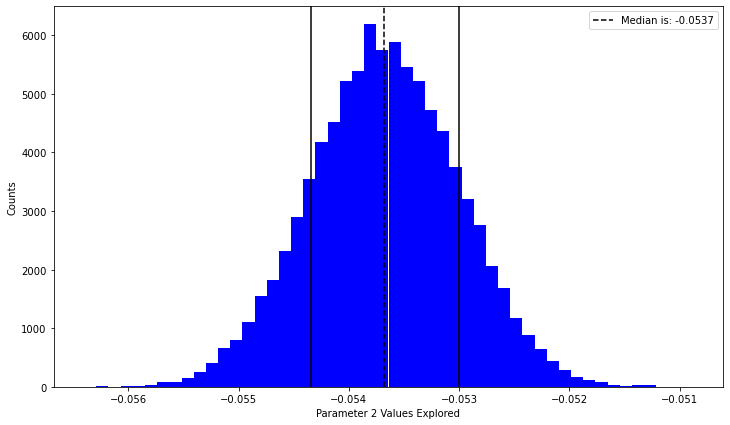

In [98]:
plt.figure(figsize = (12, 7))
plt.hist(param2_burnin, bins = 50, color = 'blue')
plt.ylabel('Counts')
plt.xlabel('Parameter 2 Values Explored')
plt.axvline(np.percentile(param2_burnin, q = 16), color = 'black')
plt.axvline(np.median(param2_burnin), color = 'black', 
            linestyle = '--', 
            label = f'Median is: {np.median(param2_burnin):.4f}')
plt.axvline(np.percentile(param2_burnin, q = 84), color = 'black')
plt.legend()
plt.show()